<a href="https://colab.research.google.com/github/spbou4ml/LLM/blob/main/workshop_image_generatif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

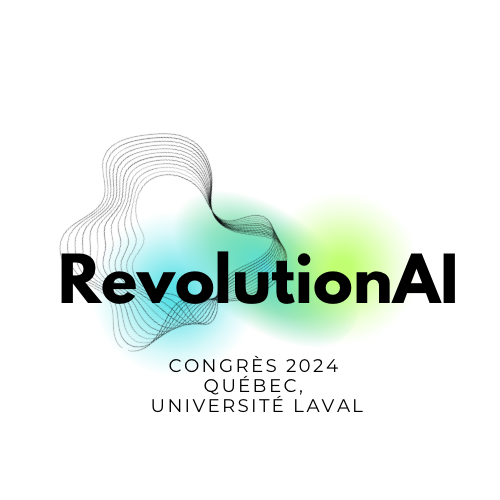

In [2]:
from IPython.display import Image
Image('/content/60781A1D-3BF5-4EE8-B32C-329B4F8CD481.PNG')

### Workshop sur le Deep Learning : Image *Génératif*

In [3]:
from tensorflow import keras

base_image_path = keras.utils.get_file(
    "sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg")
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg", origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")

original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

943128/943128 [==============================] - 1s 1us/step


In [4]:
import numpy as np

def preprocess_image(image_path):
    img = keras.utils.load_img(
        image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [5]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 [==============================] - 3s 0us/step


In [6]:
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

In [7]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [8]:
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    )
    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [9]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2"
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(
          style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [10]:
import tensorflow as tf

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        keras.utils.save_img(fname, img)

Iteration 100: loss=8137.52
Iteration 200: loss=6653.15
Iteration 300: loss=6063.29
Iteration 400: loss=5742.73
Iteration 500: loss=5536.37
Iteration 600: loss=5390.41
Iteration 700: loss=5280.47
Iteration 800: loss=5194.52
Iteration 900: loss=5125.05
Iteration 1000: loss=5067.90
Iteration 1100: loss=5019.95
Iteration 1200: loss=4979.09
Iteration 1300: loss=4943.74
Iteration 1400: loss=4912.87
Iteration 1500: loss=4885.70
Iteration 1600: loss=4861.62
Iteration 1700: loss=4840.09
Iteration 1800: loss=4820.83
Iteration 1900: loss=4803.43
Iteration 2000: loss=4787.67
Iteration 2100: loss=4773.33
Iteration 2200: loss=4760.22
Iteration 2300: loss=4748.22
Iteration 2400: loss=4737.17
Iteration 2500: loss=4726.98
Iteration 2600: loss=4717.57
Iteration 2700: loss=4708.83
Iteration 2800: loss=4700.73
Iteration 2900: loss=4693.19
Iteration 3000: loss=4686.17
Iteration 3100: loss=4679.62
Iteration 3200: loss=4673.48
Iteration 3300: loss=4667.74
Iteration 3400: loss=4662.36
Iteration 3500: loss=46

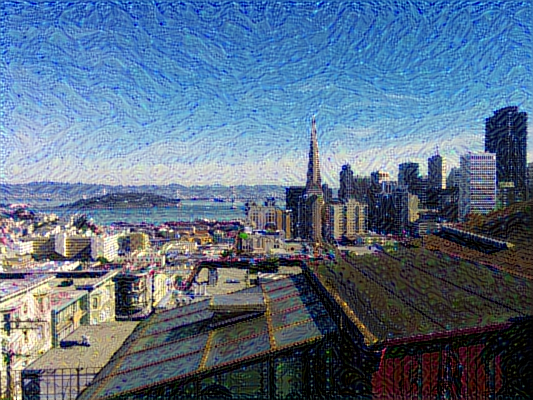

In [11]:
from IPython.display import Image
Image('/content/combination_image_at_iteration_100.png')

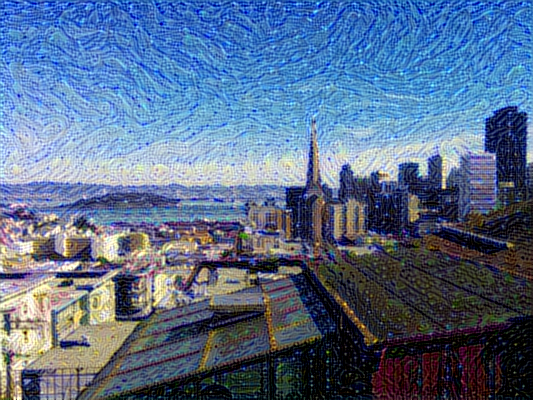

In [12]:
from IPython.display import Image
Image('/content/combination_image_at_iteration_500.png')

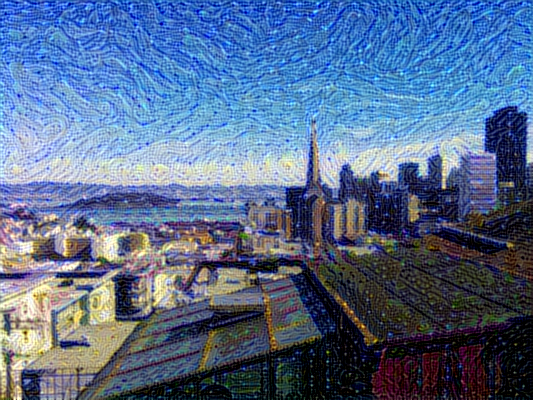

In [13]:
from IPython.display import Image
Image('/content/combination_image_at_iteration_1000.png')

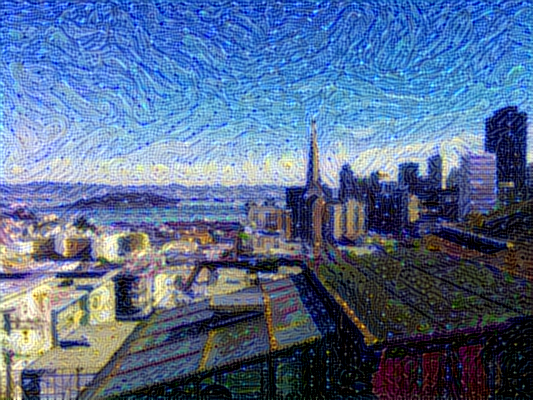

In [14]:
from IPython.display import Image
Image('/content/combination_image_at_iteration_2000.png')

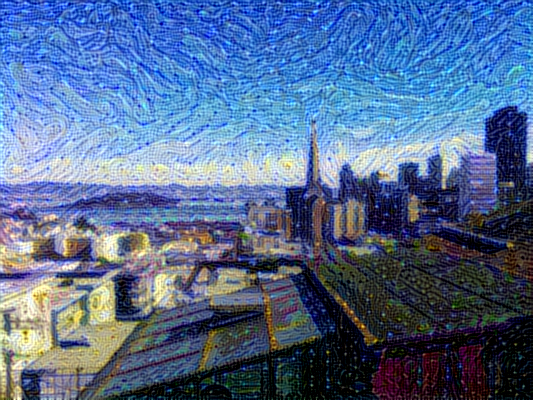

In [15]:
from IPython.display import Image
Image('/content/combination_image_at_iteration_4000.png')